In [2]:
import cudaq

import numpy as np
import scipy as sp
import scipy.stats as stats

import sympy as smp

In [3]:
def linear_indep(*mats: np.ndarray):
    vecs = [m.flatten() for m in mats]

    M = np.column_stack(vecs)
    rank = np.linalg.matrix_rank(M)
    
    return rank == len(mats)

Lie Bracket: $[A, B] = AB - BA$

$\mathfrak{g} = Lie<X, Y, Z, H, ...>$



In [4]:
# commutate
def commutator(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    return A @ B - B @ A

def single_pass(op_set: list[np.ndarray]) -> tuple[list[np.ndarray], int]:
    new_ops = []
    n = len(op_set)

    # single pass to calculate commutators
    for i in range(n):
        for j in range(i+1, n):
            H = commutator(op_set[i], op_set[j])

            # continue if 0 matrix
            if np.allclose(H, 0): 
                continue

            print(f"Calculating [op[{i}], op[{j}]]")

            curr = [m.flatten() for m in (op_set + new_ops)]
            new = curr + [H.flatten()]
            rank_curr, rank_new = np.linalg.matrix_rank(curr), np.linalg.matrix_rank(new)

            if rank_new > rank_curr:
                new_ops.append(H)

    return new_ops

def compute_dla(*generators: np.ndarray, lim: int=20) -> tuple[list, int]:
    basis = list(generators)

    i = 0
    while True:
        print(f"Iteration: {i}, basis size of {len(basis)}")

        new_ops = single_pass(basis)

        if len(new_ops) == 0:
            break

        basis.extend(new_ops)
        i+=1
        
        # with np.printoptions(precision=2, suppress=True, linewidth=1000):
        for new_op in new_ops:
            print(f"Added\n{new_op}")

        if i > lim:
            print(f"iterations exceeded {lim}, DLA loop terminated")
            break

    rank = np.linalg.matrix_rank([m.flatten() for m in basis])
    return basis, rank


$
X = 
\begin{bmatrix}
0 & 0 & 1 \\
0 & 0 & 0 \\
0 & 0 & 0
\end{bmatrix},
Y = 
\begin{bmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
1 & 0 & 0
\end{bmatrix}
$

In [5]:
X_3 = np.array([
    [0, 0, 1],
    [0, 0, 0],
    [0, 0, 0]
])

Y_3 = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [1, 0, 0]
])

dla = compute_dla(X_3, Y_3)
dla

Iteration: 0, basis size of 2
Calculating [op[0], op[1]]
Added
[[ 1  0  0]
 [ 0  0  0]
 [ 0  0 -1]]
Iteration: 1, basis size of 3
Calculating [op[0], op[1]]
Calculating [op[0], op[2]]
Calculating [op[1], op[2]]


([array([[0, 0, 1],
         [0, 0, 0],
         [0, 0, 0]]),
  array([[0, 0, 0],
         [0, 0, 0],
         [1, 0, 0]]),
  array([[ 1,  0,  0],
         [ 0,  0,  0],
         [ 0,  0, -1]])],
 np.int64(3))

$X, Y =$ random $U(2)$

In [6]:
X = stats.unitary_group.rvs(dim=3)
Y = stats.unitary_group.rvs(dim=3)

dla = compute_dla(X, Y)
dla

Iteration: 0, basis size of 2
Calculating [op[0], op[1]]
Added
[[ 0.82347832+0.39497593j  0.26425596+0.39343101j  0.74659011-0.21764095j]
 [-1.33493502+0.85110185j  0.0373219 -0.02403423j  0.27098592-0.25886861j]
 [-0.07352192+0.28088548j -0.22937454-1.15496831j -0.86080022-0.3709417j ]]
Iteration: 1, basis size of 3
Calculating [op[0], op[1]]
Calculating [op[0], op[2]]
Calculating [op[1], op[2]]
Added
[[ 0.84257712-0.3561956j   1.04639575+0.66999981j  0.21108052+0.86802903j]
 [-1.62044713-1.43696301j -1.53319519-0.44560155j -1.44975346+1.06140989j]
 [ 0.68585341+0.03382061j -1.99957561+0.32366833j  0.69061806+0.80179715j]]
Added
[[ 1.20332511-0.48623782j  1.45229548+1.06884222j  1.88150911-0.32485297j]
 [ 0.66524999-2.09289746j -0.90528924+0.3548728j  -0.46260229+1.93434012j]
 [-1.71511148-1.11227697j -1.08978566-0.34389656j -0.29803588+0.13136502j]]
Iteration: 2, basis size of 5
Calculating [op[0], op[1]]
Calculating [op[0], op[2]]
Calculating [op[0], op[3]]
Calculating [op[0], op[4]

([array([[-0.24692801-0.44513813j, -0.50870565-0.30500671j,
          -0.61661094-0.09412237j],
         [-0.52778863-0.26675157j,  0.11842859+0.49862987j,
           0.1517477 -0.60381977j],
         [ 0.09070407+0.61881672j, -0.62072007-0.01545917j,
           0.10694971-0.46029122j]]),
  array([[ 0.29540597-2.37216344e-01j, -0.31482255-8.35465331e-02j,
          -0.73135929+4.64202588e-01j],
         [-0.05111549+1.88602090e-01j, -0.61889075+7.07208122e-01j,
          -0.06876362-2.71880369e-01j],
         [-0.88700442-1.77491774e-01j,  0.10362169-4.44645344e-04j,
          -0.4032716 -9.14012273e-02j]]),
  array([[ 0.82347832+0.39497593j,  0.26425596+0.39343101j,
           0.74659011-0.21764095j],
         [-1.33493502+0.85110185j,  0.0373219 -0.02403423j,
           0.27098592-0.25886861j],
         [-0.07352192+0.28088548j, -0.22937454-1.15496831j,
          -0.86080022-0.3709417j ]]),
  array([[ 0.84257712-0.3561956j ,  1.04639575+0.66999981j,
           0.21108052+0.86802903j]

On 2 qubits

$X \otimes I$

$Y \otimes I$

In [7]:
I = np.array([
    [1, 0],
    [0, 1]
])

X = np.array([
    [0, 1],
    [1, 0]
])
Y = np.array([
    [0, -1j],
    [1j, 0]
])
Z = np.array([
    [1, 0],
    [0, -1]
])
H = np.array([
    [1 / np.sqrt(2), 1 / np.sqrt(2)],
    [1 / np.sqrt(2), -1 / np.sqrt(2)]
])

dla, dim = compute_dla(np.kron(X, I), np.kron(Y, I))
dla, dim

Iteration: 0, basis size of 2
Calculating [op[0], op[1]]
Added
[[0.+2.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+2.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-2.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-2.j]]
Iteration: 1, basis size of 3
Calculating [op[0], op[1]]
Calculating [op[0], op[2]]
Calculating [op[1], op[2]]


([array([[0, 0, 1, 0],
         [0, 0, 0, 1],
         [1, 0, 0, 0],
         [0, 1, 0, 0]]),
  array([[0.+0.j, 0.+0.j, 0.-1.j, 0.-0.j],
         [0.+0.j, 0.+0.j, 0.-0.j, 0.-1.j],
         [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j]]),
  array([[0.+2.j, 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+2.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.-2.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, 0.-2.j]])],
 np.int64(3))

Reverse engineering generators from Operation space

Retrieving generators from real circuits and computing DLA

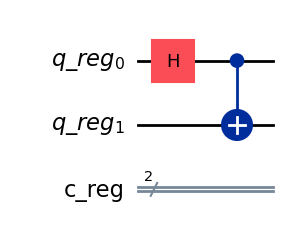

In [10]:
import qiskit.qasm3
from qiskit.quantum_info import Operator, SparsePauliOp
import pathlib

# cudaq
# @cudaq.kernel
# def bell(n_qubits: int):
#     q_reg = cudaq.qvector(n_qubits)
#     h(q_reg[0])
#     x.ctrl(q_reg[0], q_reg[1])
#     mz(q_reg)

# def extract_gen(gate_func: function, Θ: float=0, ε: float=1e-8) -> np.ndarray:
#     U_plus = gate_func(Θ + ε)
#     U_zero = gate_func(Θ)

#     dUdθ = (U_plus - U_zero) / ε
#     H = 1j * dUdθ
#     return H

SINGLE_QUBIT_GENERATORS = {
    'x': X,
    'y': Y,
    'z': Z,
    'rx': X,
    'ry': Y,
    'rz': Z,
    'h': (X + Z) / np.sqrt(2),
}

TWO_QUBIT_GENERATORS = {
    'rxx': (X, X),
    'ryy': (Y, Y),
    'rzz': (Z, Z),
    'cx': (Z, X),   # Simplified: just use Z⊗X
    'cnot': (Z, X),
    'cz': (Z, Z),
}

def extract_generators(circuit: qiskit.QuantumCircuit) -> list[np.ndarray]:
    n = circuit.num_qubits
    generators = []
    
    for inst in circuit.data:
        gate_name = inst.operation.name.lower()
        qubits = [circuit.find_bit(q).index for q in inst.qubits]
        
        # Single-qubit gates
        if gate_name in SINGLE_QUBIT_GENERATORS:
            gen = SINGLE_QUBIT_GENERATORS[gate_name]
            H = np.eye(1, dtype=complex)
            for i in range(n):
                H = np.kron(H, gen if i == qubits[0] else I)
            generators.append(H)
        
        # Two-qubit gates
        elif gate_name in TWO_QUBIT_GENERATORS:
            op1, op2 = TWO_QUBIT_GENERATORS[gate_name]
            H = np.eye(1, dtype=complex)
            for i in range(n):
                if i == qubits[0]:
                    H = np.kron(H, op1)
                elif i == qubits[1]:
                    H = np.kron(H, op2)
                else:
                    H = np.kron(H, I)
            generators.append(H)
    
    return generators

# qiskit 
circuit = qiskit.qasm3.load("../circuits/bell.qasm")
circuit.draw('mpl')

In [13]:
generators = extract_generators(circuit)
dla = compute_dla(*generators)
dla

Iteration: 0, basis size of 2
Calculating [op[0], op[1]]
Added
[[ 0.        +0.j  0.        +0.j  0.        +0.j -1.41421356+0.j]
 [ 0.        +0.j  0.        +0.j -1.41421356+0.j  0.        +0.j]
 [ 0.        +0.j  1.41421356+0.j  0.        +0.j  0.        +0.j]
 [ 1.41421356+0.j  0.        +0.j  0.        +0.j  0.        +0.j]]
Iteration: 1, basis size of 3
Calculating [op[0], op[1]]
Calculating [op[0], op[2]]
Calculating [op[1], op[2]]
Added
[[ 0.+0.j  2.+0.j  0.+0.j -2.+0.j]
 [ 2.+0.j  0.+0.j -2.+0.j  0.+0.j]
 [ 0.+0.j -2.+0.j  0.+0.j -2.+0.j]
 [-2.+0.j  0.+0.j -2.+0.j  0.+0.j]]
Added
[[ 0.        +0.j  0.        +0.j -2.82842712+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j -2.82842712+0.j]
 [-2.82842712+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j -2.82842712+0.j  0.        +0.j  0.        +0.j]]
Iteration: 2, basis size of 5
Calculating [op[0], op[1]]
Calculating [op[0], op[2]]
Calculating [op[0], op[3]]
Calculating [op[0], op[4

([array([[ 0.70710678+0.j,  0.        +0.j,  0.70710678+0.j,
           0.        +0.j],
         [ 0.        +0.j,  0.70710678+0.j,  0.        +0.j,
           0.70710678+0.j],
         [ 0.70710678+0.j,  0.        +0.j, -0.70710678+0.j,
          -0.        +0.j],
         [ 0.        +0.j,  0.70710678+0.j, -0.        +0.j,
          -0.70710678+0.j]]),
  array([[ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
         [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j, -0.+0.j, -1.+0.j],
         [ 0.+0.j,  0.+0.j, -1.+0.j, -0.+0.j]]),
  array([[ 0.        +0.j,  0.        +0.j,  0.        +0.j,
          -1.41421356+0.j],
         [ 0.        +0.j,  0.        +0.j, -1.41421356+0.j,
           0.        +0.j],
         [ 0.        +0.j,  1.41421356+0.j,  0.        +0.j,
           0.        +0.j],
         [ 1.41421356+0.j,  0.        +0.j,  0.        +0.j,
           0.        +0.j]]),
  array([[ 0.+0.j,  2.+0.j,  0.+0.j, -2.+0.j],
         [ 2.+0.j,  0.+0.j, -2.+0.j,  0.+0.j],
